# Path–Gene Correlation Analysis

This notebook implements a flexible workflow to evaluate **correlations between gene expression and biological pathways**, as well as **pathway–pathway** or **gene–gene** relationships, using public transcriptomic datasets.

The analysis is designed for **microarray expression data** downloaded from GEO and combines:
- probe-to-gene annotation via **Bioconductor**,
- sample stratification based on metadata,
- pathway activity estimation using **GSVA**, and
- correlation analysis across biological conditions.

This notebook is intended as a **general analytical framework** for exploratory hypothesis testing, enabling the investigation of whether the expression of a gene (or gene set) is associated with the activity of a pathway of interest across samples or experimental groups.


In [7]:
geo_dataset = 'GSE59071'
dest_dir_geo_data="./geo_data"

## FUNCTIONS AND PACKS

In [17]:
import pandas as pd
import os
import GEOparse
import seaborn as sns
import numpy as np
import decoupler as dc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, conversion
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

### GEO DATASET DOWNLOAD AND PROCESSING

In [9]:
def DownloadGEOMicroArray(
    geo_code,
    dest_dir_geo_data="./geo_data",
    prefer_platform=None,
    return_gse=False
):
    """
    Download and parse a GEO **microarray** (GSE) dataset.

    PARAMETERS:
    geo_code : str --> GEO Series accession (e.g. 'GSE12345').
    dest_dir_geo_data : str --> Directory to store GEO files.
    prefer_platform : str | None --> Platform ID to select if multiple exist (e.g. 'GPL6244').
    return_gse : bool --> If True, also return the GEOparse GSE object.

    RETURNS:
    expression_data : pd.DataFrame --> Gene/probe expression matrix (rows = probes/IDs, columns = samples).
    metadata : pd.DataFrame --> Sample-level metadata parsed from GEO.
    platform_used : str --> Platform ID effectively used.
    gse : GEOparse.GSE --> GEO object (only if return_gse=True).
    """

    os.makedirs(dest_dir_geo_data, exist_ok=True)

    # Load GEO file (use local cache if available)
    gse_file = os.path.join(dest_dir_geo_data, f"{geo_code}_family.soft.gz")
    if os.path.exists(gse_file):
        gse = GEOparse.get_GEO(filepath=gse_file)
    else:
        gse = GEOparse.get_GEO(geo_code, destdir=dest_dir_geo_data)

    # Parse sample metadata (characteristics_ch1 → columns)
    rows = []
    for gsm_name, gsm in gse.gsms.items():
        char_dict = {}
        for item in gsm.metadata.get("characteristics_ch1", []) or []:
            if ":" in item:
                k, v = item.split(":", 1)
                char_dict[k.strip().lower().replace(" ", "_")] = v.strip()

        rows.append({
            "sample": gsm_name,
            "title": gsm.metadata.get("title", [None])[0],
            "source_name": gsm.metadata.get("source_name_ch1", [None])[0],
            "organism": gsm.metadata.get("organism_ch1", [None])[0],
            "platform_id": gsm.metadata.get("platform_id", [None])[0],
            **char_dict
        })

    metadata = pd.DataFrame(rows).set_index("sample").sort_index()

    # Build expression matrix (VALUE field)
    try:
        expression_data = gse.pivot_samples("VALUE")
    except Exception:
        expression_data = None

    # Platform handling
    if expression_data is None or expression_data.empty:
        platform_used = None
    else:
        platforms = metadata["platform_id"].unique()
        if len(platforms) > 1:
            if prefer_platform is None or prefer_platform not in platforms:
                expression_data, platform_used = None, None
            else:
                cols = metadata[metadata["platform_id"] == prefer_platform].index
                expression_data = expression_data[cols]
                platform_used = prefer_platform
        else:
            platform_used = platforms[0]

    if return_gse:
        return expression_data, metadata, platform_used, gse
    else:
        return expression_data, metadata, platform_used


In [20]:
def AnnotateProbesWithBioconductor(expression_data, platform_used, out_dir=None):
    """
    Annotate microarray probes using Bioconductor annotation packages via rpy2.

    PARAMETERS:
    expression_data : pd.DataFrame --> Expression matrix (rows = probes, columns = samples).
    platform_used : str --> GEO platform ID (e.g. 'GPL570', 'GPL6244').
    out_dir : str | None --> Optional output path to save the annotated matrix.

    RETURNS:
    annotated : pd.DataFrame --> Gene-level expression matrix indexed by gene SYMBOL.
    """

    # --- Select Bioconductor annotation package based on GEO platform ---
    GPL_TO_BIOC = {
        "GPL570": "hgu133plus2.db",
        "GPL96": "hgu95av2.db",
        "GPL1261": "mouse4302.db",
        "GPL6244": "hugene10sttranscriptcluster.db",
        # extend as needed
        }

    bioc_package = GPL_TO_BIOC.get(platform_used, None)
    if bioc_package is None:
        print(f"[WARNING] No automatic Bioconductor mapping for {platform_used}. Manual specification required.")

    # --- Configure pandas ↔ R converter ---
    base_conversion = conversion.get_conversion()
    local_converter = conversion.Converter("local converter", template=base_conversion)
    local_converter += pandas2ri.converter

    def r_to_pandas(r_df):
        with local_converter.context():
            return pandas2ri.rpy2py(r_df)

    # --- Send probe IDs to R ---
    probe_ids = expression_data.index.astype(str).tolist()
    ro.r.assign("probe_ids", probe_ids)

    # --- Run annotation in R ---
    ro.r(f'''
        suppressPackageStartupMessages({{
            library({bioc_package})
            library(AnnotationDbi)
        }})

        probe_ids <- as.character(probe_ids)

        mapped <- AnnotationDbi::select(
            {bioc_package},
            keys = probe_ids,
            columns = c("SYMBOL","ENSEMBL","ENTREZID"),
            keytype = "PROBEID"
        )
    ''')

    # --- Convert annotation table to pandas ---
    annot_df = r_to_pandas(ro.r("mapped"))
    annot_df = (
        annot_df.replace("NA_character_", np.nan)
                .set_index("PROBEID")
                .convert_dtypes()
                .drop_duplicates()
    )

    # --- Merge annotation with expression matrix ---
    expression_data.index = expression_data.index.astype(str)
    annot_df.index = annot_df.index.astype(str)

    annotated = expression_data.merge(
        annot_df[['SYMBOL']],
        left_index=True,
        right_index=True,
        how='left')

    # Keep only probes mapped to genes
    annotated = (
        annotated.dropna(subset=["SYMBOL"])
                 .drop_duplicates(subset=["SYMBOL"])
                 .set_index("SYMBOL"))

    if out_dir:
        annotated.to_csv(out_dir, sep='\t')
        print(f"[INFO] Annotated expression matrix exported to {out_dir}")

    print(f"[INFO] Annotation completed: {annot_df.shape[0]} probes mapped, "
          f"{annot_df[['SYMBOL','ENSEMBL','ENTREZID']].notna().any(axis=1).sum()} with ≥1 gene ID.")
    print("-----------------------------------------------------------------------------")

    return annotated



In [11]:
def FilterExpressionByMetadata(expression_data, metadata, filters):
    """
    Filter expression matrix columns (samples) based on metadata conditions.

    PARAMETERS:
    expression_data : pd.DataFrame --> Expression matrix (rows = features, columns = samples).
    metadata : pd.DataFrame --> Sample metadata indexed by sample names.
    filters : dict --> {column: value(s)} used to subset samples.
                       - single value → equality filter
                       - list/tuple/set → keeps any matching value
                       Example: {"disease": ["ulcerative colitis", "control"],
                                 "disease_activity": "active"}

    RETURNS:
    expression_filt : pd.DataFrame --> Filtered expression matrix.
    metadata_filt : pd.DataFrame --> Metadata corresponding to retained samples.
    """
  
    print(f"[INFO] Applying metadata filters: {filters}")

    mask = pd.Series(True, index=metadata.index)
    for col, vals in filters.items():
        if not isinstance(vals, (list, tuple, set)):
            vals = [vals]
        mask &= metadata[col].isin(vals)

    metadata_filt = metadata[mask]
    expression_filt = expression_data[metadata_filt.index]

    print(f"[INFO] Samples before filtering: {metadata.shape[0]}")
    print(f"[INFO] Samples after filtering: {metadata_filt.shape[0]}")
    print(f"[INFO] Filtered expression matrix shape: {expression_filt.shape}")
    print("-----------------------------------------------------------------------------")

    return expression_filt, metadata_filt


### GSVA

In [12]:
def RunGSVA(expression_data, set_name, set_list):
    """
    Run GSVA (Gene Set Variation Analysis) for a single gene set using decoupler.

    PARAMETERS:
    expression_data : pd.DataFrame --> Gene expression matrix (rows = genes, columns = samples).
    set_name : str --> Name of the gene set (used as GSVA score label).
    set_list : list --> List of genes defining the gene set.

    RETURNS:
    pd.Series --> GSVA enrichment scores per sample for the given gene set.
    """
    expr_t = expression_data.T

    # Build gene set network (decoupler format)
    gene_set = pd.DataFrame({
        'source': set_name,
        'target': set_list,
        'weight': 1})

    # Run GSVA
    gsva_result = dc.mt.gsva(
        data=expr_t,
        net=gene_set,
        verbose=True)

    # Extract GSVA scores
    scores_df = gsva_result[0].copy()
    scores_df = scores_df.apply(pd.to_numeric, errors='coerce')

    # Single gene set → return as Series
    scores = scores_df.iloc[:, 0]
    scores.name = set_name

    return scores


### CORRELATION

In [13]:
def PlotColoredScatterWithGroupStats(df, stats, xcol, ycol,
                                     group_col="group", title=None,
                                     order=None, palette=None,
                                     legend_loc='upper left',
                                     out_figure=None):
    """
    Plot a group-colored scatter with a global regression line and 95% CI,
    using precomputed group-level statistics for the legend.

    PARAMETERS:
    df : pd.DataFrame --> Data matrix containing x/y values and group labels.
    stats : pd.DataFrame --> Precomputed statistics per group (rho, p, n).
    xcol, ycol : str --> Column names for X and Y axes.
    group_col : str --> Column defining sample groups.
    title : str or None --> Plot title.
    order : list or None --> Explicit group plotting order.
    palette : dict or None --> Mapping {group: color}.
    legend_loc : str --> Legend location.
    out_figure : str or None --> Path to save figure (if provided).

    RETURNS:
    None --> Displays the plot and optionally saves it to disk.
    """

    # define group order and colors
    if order is None:
        order = sorted(df[group_col].dropna().unique())
    if palette is None:
        import seaborn as sns
        colors = sns.color_palette("Set1", len(order))
        palette = {g: c for g, c in zip(order, colors)}

    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

    # scatter points by group
    for g, d in df.groupby(group_col):
        ax.scatter(d[xcol], d[ycol], s=50, alpha=0.9,
                   label=g, color=palette.get(g, "gray"))

    # global linear fit (OLS) + 95% confidence interval (visual aid only)
    X = sm.add_constant(df[xcol].values)
    fit = sm.OLS(df[ycol].values, X).fit()
    xx = np.linspace(df[xcol].min(), df[xcol].max(), 200)
    XX = sm.add_constant(xx)
    pred = fit.get_prediction(XX)
    mean = pred.predicted_mean
    ci_low, ci_high = pred.conf_int().T
    ax.plot(xx, mean, color="red", lw=2)
    ax.fill_between(xx, ci_low, ci_high, color="red", alpha=0.18, zorder=0)

    # axes and grid
    ax.set_xlabel(xcol, fontsize=18)
    ax.set_ylabel(ycol, fontsize=18)
    if title:
        ax.set_title(title)
    ax.grid(alpha=0.35, linestyle=":")
    ax.axhline(0, color="#999", lw=1, alpha=0.5)

    # legend with group statistics (rho, p-value, n)
    handles = []
    for _, r in stats.iterrows():
        color = palette.get(r["group"], "gray")
        h = plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=color, markersize=8,
                       label=f"{r['group']} (n={int(r['n'])}): "
                             f"ρ={r['rho']:.2f}, p={r['p']:.2e}")
        handles.append(h)
    ax.legend(handles=handles, loc=legend_loc, frameon=True, title="Groups")

    plt.tight_layout()

    # save figure if requested
    if out_figure:
        plt.savefig(out_figure, dpi=500, bbox_inches="tight")

    plt.show()


In [14]:
def ApplyCorrelation1Plot(set1: list, set2: list, name_set1: str, name_set2: str, 
                          title: str = None, group_by: str = None, palette = None, 
                          legend_loc='upper left', out_figure=None):
    """
    Compute Spearman correlation between two genes or gene sets and generate
    a group-colored scatter plot with global trend and group-wise statistics.

    PARAMETERS:
    set1, set2 : list --> Single gene (len=1) or gene set (len>1).
    name_set1, name_set2 : str --> Labels for X and Y axes.
    title : str or None --> Plot title.
    group_by : str or None --> Metadata column used for grouping samples.
    palette : dict or None --> Mapping {group: color}.
    legend_loc : str --> Legend location.
    out_figure : str or None --> Path to save the figure.

    RETURNS:
    df_clean : pd.DataFrame --> Samples without NaNs used in correlation.
    df_nan   : pd.DataFrame --> Samples containing NaNs (excluded).
    stats    : pd.DataFrame --> Spearman statistics per group + global ('all').
    """
 

    # --- compute scores (GSVA for gene sets, expression for single genes) ---
    scores_dic = {
        1: {"set_list": set1, "name": name_set1},
        2: {"set_list": set2, "name": name_set2},
    }

    for n in [1, 2]:
        if len(scores_dic[n]["set_list"]) > 1:
            scores_dic[n]["scores"] = RunGSVA(
                expression_data, scores_dic[n]["name"], scores_dic[n]["set_list"]
            )
        else:
            gene = scores_dic[n]["set_list"][0]
            scores_dic[n]["scores"] = expression_data.loc[gene]

    # --- assemble data frame with group annotation ---
    df_gene_score = pd.DataFrame({
        name_set1: scores_dic[1]["scores"],
        name_set2: scores_dic[2]["scores"],
    })

    if group_by is not None:
        df_gene_score["group"] = metadata[group_by]
    else:
        df_gene_score["group"] = "all"

    # --- NaN handling ---
    mask_nan = df_gene_score.isna().any(axis=1)
    df_nan = df_gene_score[mask_nan]
    if mask_nan.sum() > 0:
        print(f"[INFO] {mask_nan.sum()} samples contain NaN values.")
    df_clean = df_gene_score.dropna()

    # --- Spearman correlation (global + per group) ---
    rho_all, p_all = spearmanr(df_clean[name_set1], df_clean[name_set2])

    rows = []
    for g, d in df_clean.groupby("group"):
        if len(d) > 1:
            rho, p = spearmanr(d[name_set1], d[name_set2])
            rows.append({"group": g, "n": len(d), "rho": rho, "p": p})

    rows.append({"group": "all", "n": len(df_clean), "rho": rho_all, "p": p_all})
    stats = pd.DataFrame(rows)

    # --- plot ---
    if not title:
        title = f"Correlation {name_set1} x {name_set2}"

    PlotColoredScatterWithGroupStats(
        df_clean,
        stats=stats,
        xcol=name_set1,
        ycol=name_set2,
        group_col="group",
        title=title,
        palette=palette,
        legend_loc=legend_loc,
        out_figure=out_figure
    )

    return df_clean, df_nan, stats



## EXECUTION

### 1. Download GEO dataset and inspect metadata

In [18]:
# Step 1 
# - Downloads the GEO microarray dataset
# - Extracts expression matrix, sample metadata, and platform information
# - Metadata inspection is required to:
#     (i) identify experimental groups available for filtering
#     (ii) confirm which microarray platform was used

expression_data, metadata, platform_used = DownloadGEOMicroArray(
    geo_dataset,
    dest_dir_geo_data=dest_dir_geo_data
)

26-dez-2025 13:59:15 DEBUG utils - Directory ./geo_data already exists. Skipping.
2025-12-26 13:59:15 | [DEBUG] Directory ./geo_data already exists. Skipping.
26-dez-2025 13:59:15 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE59nnn/GSE59071/soft/GSE59071_family.soft.gz to ./geo_data/GSE59071_family.soft.gz
2025-12-26 13:59:15 | [INFO] Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE59nnn/GSE59071/soft/GSE59071_family.soft.gz to ./geo_data/GSE59071_family.soft.gz
100%|██████████| 42.5M/42.5M [00:14<00:00, 3.16MB/s]
26-dez-2025 13:59:32 DEBUG downloader - Size validation passed
2025-12-26 13:59:32 | [DEBUG] Size validation passed
26-dez-2025 13:59:32 DEBUG downloader - Moving /tmp/tmpklkhcf33 to /home/tahila/00.github/path-gene-correlations/geo_data/GSE59071_family.soft.gz
2025-12-26 13:59:32 | [DEBUG] Moving /tmp/tmpklkhcf33 to /home/tahila/00.github/path-gene-correlations/geo_data/GSE59071_family.soft.gz
26-dez-2025 13:59:32 DEBUG downloader - Successfully d

### 2. Probe annotation and sample filtering

In [21]:
# - Annotates microarray probes to gene symbols using Bioconductor
# - Defines biological categories to retain based on sample metadata
#   (disease status and disease activity)

# Probe-to-gene annotation
annotated = AnnotateProbesWithBioconductor(
    expression_data,
    platform_used,
    out_dir=f'{dest_dir_geo_data}/{geo_dataset}_expr_matrix_annotated.csv')

# Filter samples based on metadata categories of interest
expression_data, metadata_filtered = FilterExpressionByMetadata(
    annotated,
    metadata,
    filters={
        "disease": ["ulcerative colitis", "control"],
        "disease_activity": ["active", "inactive", "normal"]})

2025-12-26 14:01:58 | [WARNING] R callback write-console: 'select()' returned 1:many mapping between keys and columns
  


[INFO] Annotated expression matrix exported to ./geo_data/GSE59071_expr_matrix_annotated.csv
[INFO] Annotation completed: 24623 probes mapped, 24623 with ≥1 gene ID.
-----------------------------------------------------------------------------
[INFO] Applying metadata filters: {'disease': ['ulcerative colitis', 'control'], 'disease_activity': ['active', 'inactive', 'normal']}
[INFO] Samples before filtering: 116
[INFO] Samples after filtering: 108
[INFO] Filtered expression matrix shape: (21179, 108)
-----------------------------------------------------------------------------


### 3. Correlation ploting

Automatically computes GSVA scores for gene sets, or directly uses expression values when a single gene is provided

2025-12-26 14:05:12 | [INFO] gsva - Running gsva
2025-12-26 14:05:12 | [INFO] Extracted omics mat with 108 rows (observations) and 21179 columns (features)
2025-12-26 14:05:12 | [INFO] Network has 13 unique features and 1 unique sources
2025-12-26 14:05:12 | [INFO] gsva - computing density with kcdf=gaussian
2025-12-26 14:05:19 | [INFO] gsva - calculating 1 scores with maxdiff=True, absrnk=False


  0%|          | 0/1 [00:00<?, ?it/s]

2025-12-26 14:05:19 | [INFO] gsva - done


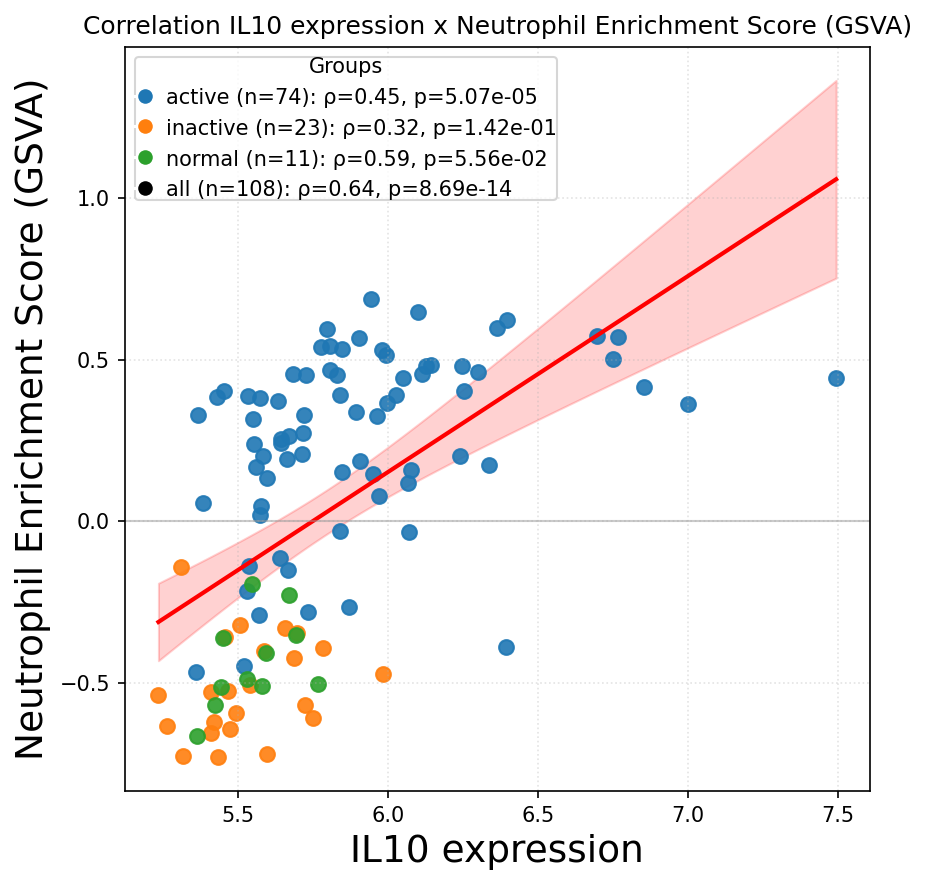

In [24]:
# ------------------------------------------------------------------
# Define a pathway related gene set (neutrophil recruitment, in this example) to compute an enrichment score
# using GSVA, and a single-gene list (IL10) for direct expression-based
# correlation analysis.
# ------------------------------------------------------------------

genes_path = [
    "FCGR3B", "CEACAM8", "CSF3R", "CXCR1", "CXCR2",
    "ITGAM",  "MPO", "ELANE", "PRTN3",
    "CTSG", "LTF", "MMP8", "OLFM4", "CD66B"
]

# Single-gene list: expression values will be used directly (no GSVA)
gene = ["IL10"]


# ------------------------------------------------------------------
# Compute correlation between:
#   - IL10 expression (single gene)
#   - Neutrophil enrichment score (GSVA-based gene set)
#
# The analysis:
#   - Computes GSVA automatically for multi-gene sets
#   - Uses raw expression when a single gene is provided
#   - Stratifies samples by disease activity
#   - Computes Spearman correlations per group and globally
#   - Generates a publication-ready scatter plot
# ------------------------------------------------------------------

df_clean, df_nan, stats = ApplyCorrelation1Plot(
    gene, genes_path,
    "IL10 expression",
    "Neutrophil Enrichment Score (GSVA)",
    group_by="disease_activity",
    palette={
        "active": "#1f77b4",
        "inactive": "#ff7f0e",
        "normal": "#2ca02c",
        "all": "black"
    },
    title="",
    out_figure="correlation.png"
)
